In [1]:
cd /home/tkim/Academics/EdgeAlloc/

/home/tkim/Academics/EdgeAlloc


In [2]:
%load_ext autoreload
%autoreload 2

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm, tqdm_notebook

# Import tools
import tools.solver_utils as ts
import tools.other_utils as to
import tools.sim_utils as tm

# Import classes
from classes.User import *
from classes.Server import *

In [23]:
# testing user markov chain 
U = 1
K = 4
T = 10000

space_1d_dim = 10
num_locs = 9

# Generate visitng locations and server locations
usr_locs = tm.gen_eq_locs(space_1d=space_1d_dim, nums=num_locs, offset = 1.7)
svr_locs = tm.gen_eq_locs(space_1d=space_1d_dim, nums=K, offset = 1.7)
capacity = np.ones(K) * 2

mu = np.random.uniform(low=0.0, high=1.0, size=[U,K])

servers = []
for s in range(len(svr_locs)):
    servers += [Server(capacity[s], s, mu, svr_locs[s])]

users = []
for i in range(U):
    users += [User(servers, T, locs)]
    
regret_central = np.zeros(T)
regret_dist = np.zeros(T)



In [22]:
capacity

array([2., 2., 2., 2.])

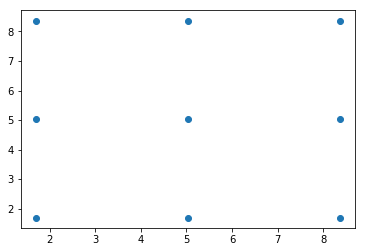

In [17]:
x = [p[0] for p in usr_locs]
y = [p[1] for p in usr_locs]

# Create a scatter plot of the points
plt.scatter(x, y)